In [1]:
import pandas as pd
import glob
import missingno as msno
from tqdm import tqdm_notebook
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import locale
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Nanum Brush Script OTF'
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
locale.setlocale(locale.LC_ALL,'en_US.UTF-8')

'en_US.UTF-8'

# Dam Data

In [3]:
#Removes comma and blank spaces from a number
def blk_rm(x):    
    x = str(x).strip()
    x = locale.atof(x)
    return x

In [4]:
def dam_data(root_dir):
    df_lst = []
    print('begin merging dam data.......')
    
    data_loc = glob.glob(root_dir)
    for data in data_loc:
        data_comb = pd.read_excel(data)
        df_lst.append(data_comb)

    df_dam = pd.concat(df_lst)
    df_dam.dropna(how='all',inplace=True)
    df_dam = df_dam.set_index('일시')
    df_dam = df_dam.sort_index()
    df_dam.index = pd.to_datetime(df_dam.index)
    df_dam = df_dam.iloc[:,:13]
    
    for col in df_dam.columns:
        #print(final_data_comb[col].dtype)
        if df_dam[col].dtype == 'float64':
            pass
        else:
            df_dam[col] = df_dam[col].apply(blk_rm)
    df = df_dam[['강우량(mm)', '유입량(㎥/s)']]
    return df

# weather

In [5]:
def weather_data_process(data_loc):
    data_lst = glob.glob(data_loc)
    data_comb = pd.concat([pd.read_csv(f,encoding='euc-kr',index_col=1) for f in data_lst])
    data_comb = data_comb.drop(['지점'], axis=1)
    #data_comb.index = data_comb.set_index('일시')
    col_lst = [
              '최저기온(°C)',
              '최고기온(°C)',
              '평균 풍속(m/s)',
              '평균 상대습도(%)',
              '합계 일사(MJ/m2)'
               ]
    
    df_weather = data_comb[col_lst]
    #msno.matrix(df_weather) #Check if there is any missing data
    
    df_weather['평균 상대습도(%)'] = df_weather['평균 상대습도(%)'].interpolate(method='linear')# filling missing data
    df_weather['평균 풍속(m/s)'] = df_weather['평균 풍속(m/s)'].interpolate(method='linear')#filling missing data
    df_weather['합계 일사(MJ/m2)'] = df_weather['합계 일사(MJ/m2)'].interpolate(method='linear')
    df_weather.index = pd.to_datetime(df_weather.index)
    df_weather.index = df_weather.index.sort_values()
    df_weather = df_weather.sort_index()
    df_weather.index = pd.to_datetime(df_weather.index)
    assert df_weather.isnull().sum().sum() == 0
    
    return df_weather
    

In [6]:
def data_merger(df1,df2):
    df_new = df1.join(df2,how='outer')
    df_new = df_new[df_new.index >'2004-07-03']
    assert df_new.isnull().sum().sum() ==0
    
    return df_new

# Merging

begin merging dam data.......
begin merging dam data.......DONE


Check if there are any missing values....
Check if there are any missing values....DONE


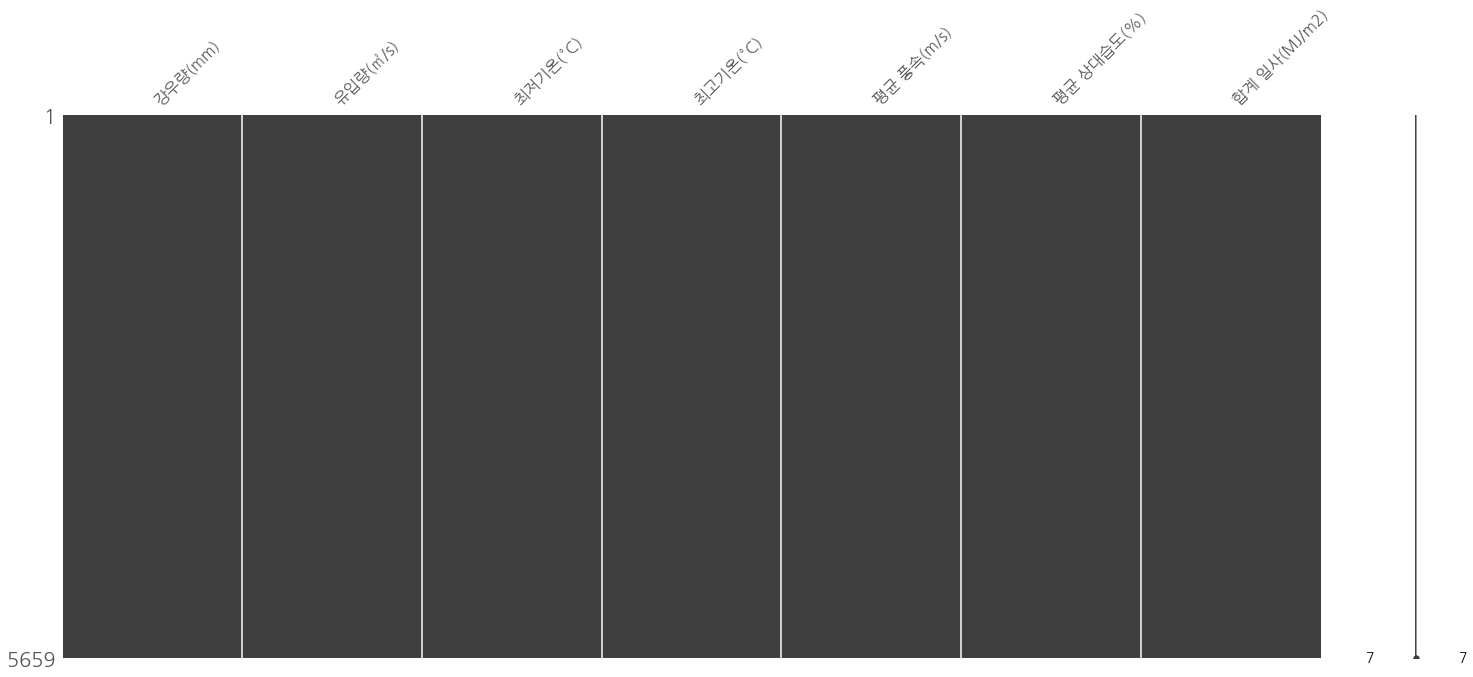

In [7]:
#Dam data
dam_data_dir = r'..//Dam_daily_data//*'
df_dam = dam_data(dam_data_dir)

#Weather data
weather_data_dir = '../Dam_weather_data/*.csv'
df_weather = weather_data_process(weather_data_dir)

#weather + dam data
df_merged = data_merger(df_dam,df_weather)
print('begin merging dam data.......DONE\n\n')
print('Check if there are any missing values....')
msno.matrix(df_merged)
print('Check if there are any missing values....DONE')

In [8]:
df_merged.to_csv('../Dam_weather_warning/weather_dam_data.csv',header=True, index=True,encoding='euc-kr')